In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
DOMAIN_SIZE = 100.0
N_DOF = 200
DT = 0.1

In [16]:
class KuramotoSivashinsky():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_next_hat = self.exp_term * u_hat + self.coef * u_nonlin_der_hat
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)
        return u_next

In [17]:
mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)

In [18]:
u_0 = jnp.sin(16 * jnp.pi * mesh / DOMAIN_SIZE)

In [19]:
ks_stepper = KuramotoSivashinsky(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
)

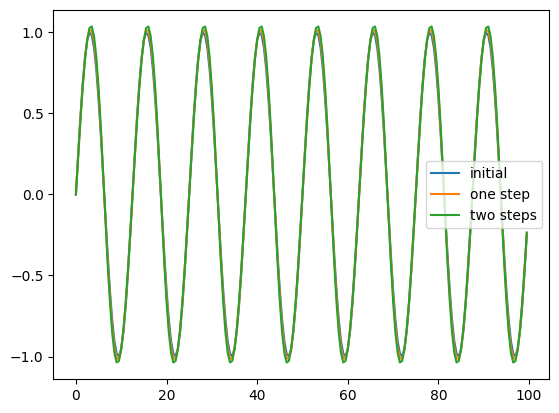

In [20]:
plt.plot(mesh, u_0, label="initial")
plt.plot(mesh, ks_stepper(u_0), label="one step")
plt.plot(mesh, ks_stepper(ks_stepper(u_0)), label="two steps")
plt.legend()

In [21]:
ks_stepper = jax.jit(ks_stepper)

In [22]:
u_current = u_0
trj = [u_current, ]
for i in range(2000):
    u_current = ks_stepper(u_current)
    trj.append(u_current)

trj = jnp.stack(trj)

Text(0, 0.5, 'space')

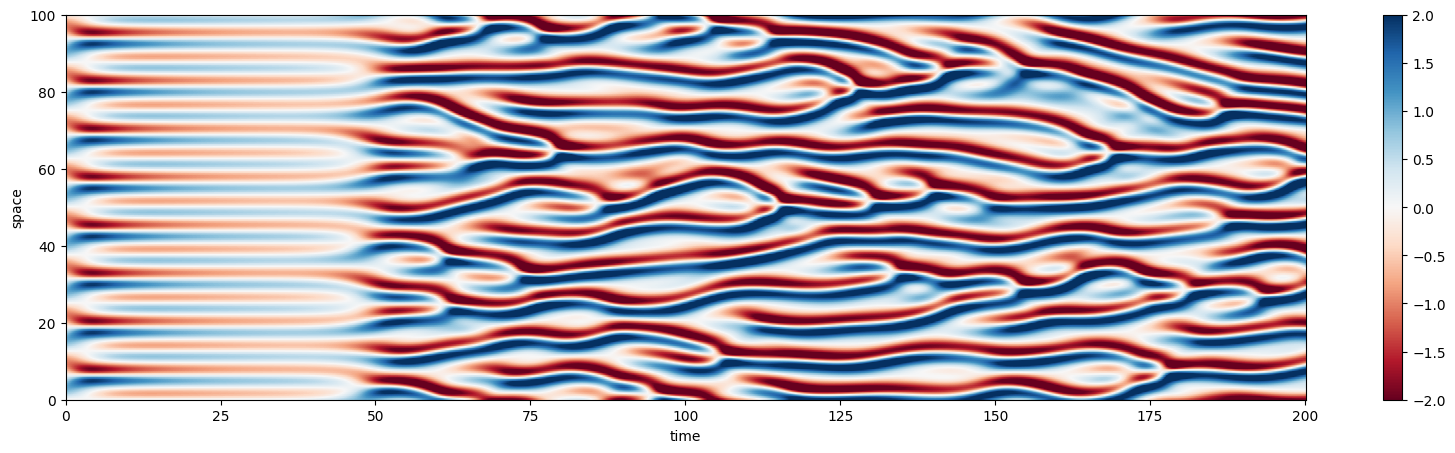

In [23]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj.T,
    cmap="RdBu",
    aspect="auto",
    origin="lower",
    extent=(0, trj.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")

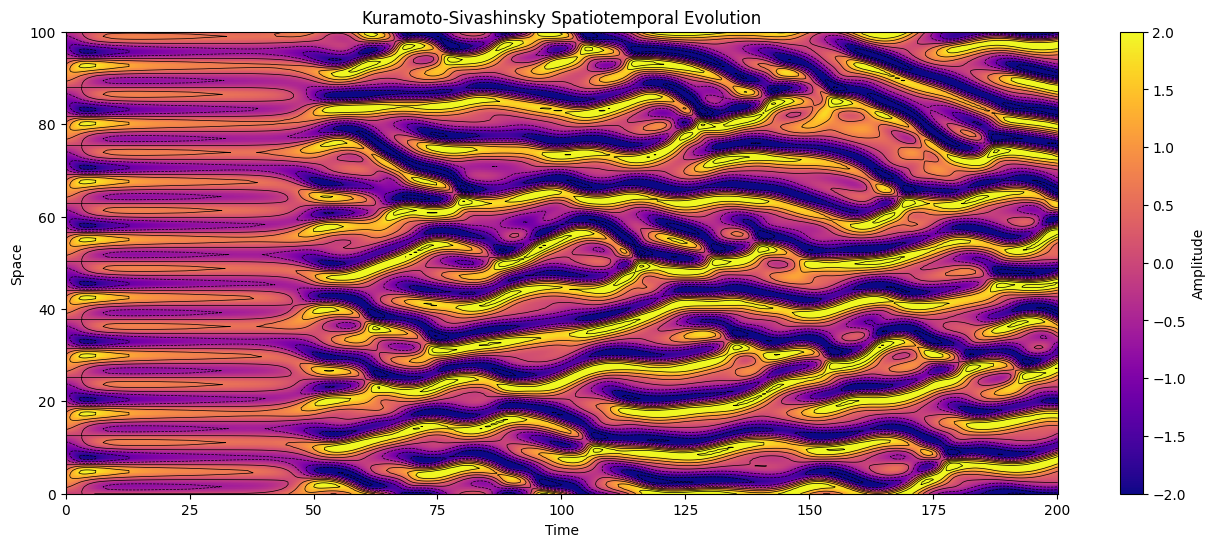

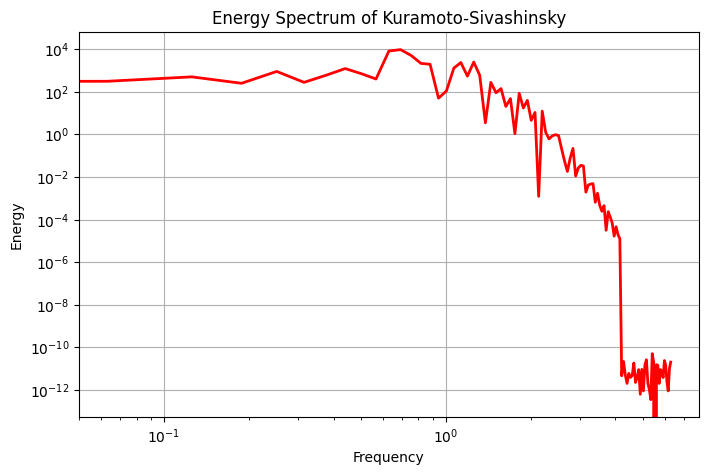

In [25]:
u_current = u_0
trj = [u_current]
for i in range(2000):
    u_current = ks_stepper(u_current)
    trj.append(u_current)
trj = jnp.stack(trj)

# Heatmap visualization
plt.figure(figsize=(16, 6))
plt.imshow(
    trj.T,
    cmap="plasma",
    aspect="auto",
    origin="lower",
    extent=(0, trj.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar(label="Amplitude")
plt.xlabel("Time")
plt.ylabel("Space")
plt.title("Kuramoto-Sivashinsky Spatiotemporal Evolution")

# Adding contour lines for better aesthetics
plt.contour(trj.T, levels=10, linewidths=0.5, colors="k", extent=(0, trj.shape[0] * DT, 0, 100))
plt.show()
energy_spectrum = jnp.abs(jnp.fft.rfft(trj[-1]))**2  # Power spectrum
frequencies = jnp.fft.rfftfreq(N_DOF, d=DOMAIN_SIZE / (N_DOF * 2 * jnp.pi))

plt.figure(figsize=(8, 5))
plt.loglog(frequencies, energy_spectrum, 'r', lw=2)
plt.xlabel("Frequency")
plt.ylabel("Energy")
plt.title("Energy Spectrum of Kuramoto-Sivashinsky")
plt.grid(True)
plt.show()